## Importación de librerías

In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import os
import tempfile
import numpy as np
import pandas as pd
import csv
import string
import json
import tensorflow as tf
import pickle
import copy

import operator
import math

import matplotlib.pyplot as plt
import seaborn as sns

#Import Document Set
from gensim import corpora, models, similarities
#from gensim.models.phrases import Phrases, Phraser
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

C:\Users\Victor\Anaconda3\envs\tensorflowCPU\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2019-05-03 10:22:53,857 : INFO : 'pattern' package not found; tag filters are not available for English


## Preprocesamiento

In [2]:
#Read a json file
def open_file(fname):
    with open(fname) as jsonfile:
            resumes = json.load(jsonfile)
    return resumes

In [3]:
# Generation of a list [actualjob + jobsexperience]
def create_arr_by_job(resumes):
    df=pd.DataFrame(resumes)
    job_desc=[]
    for cv in df.Resume:
        puesto=cv["job"].lower()
        desc=cv["summary"].lower()
        if len(desc)>0:
            job_desc.append([puesto,desc.replace("\\n","\n")])

    print('Total de CV:{}'.format(len(job_desc)))
    i=0
    for cv in df.Resume:
        puesto=''
        desc=''
        for ex in cv["experience"]:
            try:
                puesto=ex["e_job"].lower()
            except KeyError:
                print('Campo job vacio')
            try:
                desc=ex["e_activities"].lower()
            except KeyError:
                print('Campo activities vacio')
            if len(desc)>0:
                job_desc.append([puesto,desc])
                i=i+1
    print('Total de puestos por experiencia:{}'.format(i))        
    print('Total de puestos extraidos:{}'.format(len(job_desc)))
    return job_desc

# Jobs labeling Funtion 
def label_jobs(temp_file,job_desc):
    f= open(temp_file,"w+")
    jobs_labeled=[]
    documents=[]

    for job in job_desc:
        #Jobs Labeling
        if job[0].find("vice president")!= -1 or job[0].find("delivery manager")!= -1 or job[0].find(" vp ")!= -1 or job[0].find("svp ")!= -1:
            f.write("{} \t|\t vice president or equivalent\n".format(job[0]))
            label="vice president or equivalent"
        else :
            if job[0].find("president")!= -1:
                    f.write("{} \t|\t president or equivalent\n".format(job[0])) 
                    label="president or equivalent"
            else:            
                if job[0].find("director")!= -1:
                    f.write("{} \t|\t director or equivalent\n".format(job[0]))
                    label="director or equivalent"
                else:
                    if job[0].replace("sr","senior").find("senior project manager")!= -1 or (job[0].replace("sr","senior").find("senior")!= -1
                            and job[0].find("project manager")!= -1) or ( job[0].replace("programme","program").find("program")!= -1 and job[0].find("manager")!= -1):
                            f.write("{} \t|\t senior project manager or equivalent\n".format(job[0].replace("|",",")))
                            label="senior project manager or equivalent"
                    else:
                        if job[0].find("project manager")!= -1 or (job[0].find("project")!= -1 and job[0].replace("management","manager").find("manager")!= -1) or job[0].find("project coordinator")!= -1 or job[0].find("project consultant")!= -1 or (
                            job[0].find("manager")!= -1 ):
                            f.write("{} \t|\t project manager or equivalent\n".format(job[0].replace("|",",")))
                            label="project manager or equivalent"
                        else:
                            if job[0].find("leader")!= -1 or job[0].find("lead")!= -1:
                                f.write("{} \t|\t project leader or equivalent\n".format(job[0].replace("|",",")))
                                label="project leader or equivalent"
                            else:
                                if job[0].replace("sr","senior").find("senior")!= -1 or (job[0].find("technology")!= -1 and job[0].find("analyst")!= -1):
                                    f.write("{} \t|\t senior consultant or equivalent\n".format(job[0].replace("|",",")))
                                    label="senior consultant or equivalent"
                                else:
                                    if job[0].find("develop")!= -1 or job[0].find("system")!= -1 or job[0].find("tech")!= -1 or  job[0].find("analyst")!= -1 or  job[0].find("software")!= -1 or  job[0].find("it")!= -1 or  job[0].find("oracle")!= -1 or  job[0].find("consultant")!= -1 or  job[0].replace("jr","junior").find("junior")!= -1 or  job[0].find("engineer")!= -1:
                                        f.write("{} \t|\t it consultant or equivalent\n".format(job[0].replace("|",",")))
                                        label="it consultant or equivalent"
                                    else:
                                        f.write("{} \t|\t OOB\n".format(job[0].replace("|",",")))
                                        label="OOB"

        jobs_labeled.append([label,job[0],job[1].replace("\\n","\n").replace("   "," ").replace("  "," ").lower()])
    f.close()
    print("Archivo temporal creado en: {}".format(os.getcwd()))
    return documents,jobs_labeled

In [4]:
# Definition of the paths to be used
fpath= os.getcwd()
fname= 'C:\\Users\\Victor\\Documents\\LinkedIn Input/LinkedinCV(300)_2.json'
fmodelname = os.path.join(fpath,'Model/Doc2vecForSentences.model')
temp_file='JobsLabeled.txt'

In [5]:
resumes = open_file(fname)
job_desc = create_arr_by_job(resumes)
_,jobs_labeled = label_jobs(temp_file,job_desc)

Total de CV:234
Total de puestos por experiencia:1340
Total de puestos extraidos:1574
Archivo temporal creado en: C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding


In [1]:
#Sentence tokenization 
def token_separation(sDescription="",splitted=True,bSentence=False,bStopwords=False):
    
    sentenceTkn = []
    
    #Use of stopwords
    stoplist = []
    if bStopwords:
        stoplist = list(set(stopwords.words('english')))
        stoplist.extend(["–","/","&",".","$","(",")","!","?",";",":","'",",","“","”","’"])
    
    #Convert Description to sentence and Tokenization of words
    tnzr = nltk.tokenize
    if bSentence:
#         sentences= sDescription.split(".")
        sDescription=sDescription.replace(" \n ","\n").replace(" \n","\n").replace("\n ","\n").replace("\n",".\n<sen>").replace("..\n",".\n")
#         print(sDescription,"\n************")
        sentences = sent_tokenize(sDescription)
#         print(sentences)
        for sen in sentences:
            tnkstr= tnzr.word_tokenize(sen.replace("<sen>",""))
            
            i_offset = 0
            for i, t in enumerate(tnkstr):
                i -= i_offset
                if t == '#' and i > 0:
                    left = tnkstr[:i-1]
                    joined = [tnkstr[i - 1] + t]
                    right = tnkstr[i + 1:]
                    tnkstr = left + joined + right
                    i_offset += 1
    
            lSenTkn=[word for word in tnkstr if (word not in stoplist)]
            if len(lSenTkn)>0:
                if splitted:
                    sentenceTkn.append(lSenTkn)
                else:
                    sentenceTkn.extend(lSenTkn)
    else:
        sentences = sDescription
        tnkstr= tnzr.word_tokenize(sentences)   
        sentenceTkn = [word for word in tnkstr if (word not in stoplist)]

    return sentenceTkn


In [7]:
jobs_labeled[13]

['project manager or equivalent',
 'data & analytics project manager',
 'software development life cycle using agile/scrum and cmmi\nmore than 16 years of experience in the software development industry with international exposure.\ndetail and results oriented with strong analytic skills in producing, managing, processing and communicating business requirements and information to excel customer satisfaction and business operations.\nspecialties: project management, software development in c#, sql server and asp.net.']

In [63]:
# token_separation(jobs_labeled[0][2],bSentence=True,bStopwords=True)

## Creación de tagged documents

In [8]:
#Tagged Documents
jobSentnc_tkn = []
documents = []
for d in jobs_labeled:
    jobSentnc_tkn.append([d[0],d[1],token_separation(d[2],bSentence=True,bStopwords=True)])
    documents.append(TaggedDocument(token_separation(d[2],bStopwords=True),[d[0].replace(" ","_")]))

In [65]:
jobSentnc_tkn[13]

['project manager or equivalent',
 'data & analytics project manager',
 [['software', 'development', 'life', 'cycle', 'using', 'agile/scrum', 'cmmi'],
  ['16',
   'years',
   'experience',
   'software',
   'development',
   'industry',
   'international',
   'exposure'],
  ['detail',
   'results',
   'oriented',
   'strong',
   'analytic',
   'skills',
   'producing',
   'managing',
   'processing',
   'communicating',
   'business',
   'requirements',
   'information',
   'excel',
   'customer',
   'satisfaction',
   'business',
   'operations'],
  ['specialties',
   'project',
   'management',
   'software',
   'development',
   'c#',
   'sql',
   'server',
   'asp.net']]]

In [11]:
documents

[TaggedDocument(words=['15', 'years', 'qualified', 'leadership', 'experience', 'project', 'management', 'quality', 'assurance', 'qa', 'configuration', 'management', 'requirements', 'analysis', 'testing', 'evaluation', 'led', 'integrated', 'software', 'hardware', 'test', 'teams', 'multiple', 'projects', 'conducted', 'qa/audits', 'highly', 'regulated', 'industries', 'adhering', 'food', 'drug', 'administration', 'regulations', 'iso', '9001.', 'extensive', 'experience', 'automated', 'installation', 'entry', 'system', 'aie', 'integrated', 'commercial', 'intrusion', 'detection', 'system', 'icids', 'bio-tech', 'medical', 'equipment', 'enterprise', 'system', 'website', 'testing', 'applications', 'graphic', 'user', 'interface', 'gui', 'participated', 'system', 'design', 'architecture', 'review', 'areas', 'expertise', 'full', 'range', 'qa', 'concepts', 'project', 'management', 'scope', 'management', 'time', 'management', 'site', 'management', 'fielding', 'risk', 'management', 'communications', '

# Definición y Entrenamiento del modelo

## Hiperparametros

In [68]:
mDistMem = 0              # {0:"Distributed Bag of Words PV-DBOW",1:"Distributed Memory PV-DM"}
mAlphaM= 0.025            # Initial Learning rate
mEmbeddingDim = 200       # Dimnesionality of the feature vectors
mWindow= 10               # Maximum distance between the current and the predicted word 
mMinAlpha = 0.02          # Learning rate will linearly drop to min alpha  as training progresses
mMinCount = 1             # Ignores all words with total frecuency lower than this

## Definición del modelo

In [71]:
# Model definition 
model = models.Doc2Vec(documents, dm = mDistMem, alpha=mAlphaM, vector_size= mEmbeddingDim,window=mWindow, min_alpha=mMinAlpha, min_count=mMinCount)

2019-02-11 13:01:51,787 : INFO : collecting all words and their counts
2019-02-11 13:01:51,787 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2019-02-11 13:01:51,813 : INFO : collected 11469 word types and 9 unique tags from a corpus of 1574 examples and 93968 words
2019-02-11 13:01:51,814 : INFO : Loading a fresh vocabulary
2019-02-11 13:01:51,836 : INFO : effective_min_count=1 retains 11469 unique words (100% of original 11469, drops 0)
2019-02-11 13:01:51,836 : INFO : effective_min_count=1 leaves 93968 word corpus (100% of original 93968, drops 0)
2019-02-11 13:01:51,869 : INFO : deleting the raw counts dictionary of 11469 items
2019-02-11 13:01:51,870 : INFO : sample=0.001 downsamples 41 most-common words
2019-02-11 13:01:51,871 : INFO : downsampling leaves estimated 88472 word corpus (94.2% of prior 93968)
2019-02-11 13:01:51,906 : INFO : estimated required memory for 11469 words and 200 dimensions: 24093900 bytes
2019-02-11 13:01:51,906 : INFO : r

## Training

In [72]:
model.train(documents,total_examples=len(documents),epochs=500)

2019-02-11 13:04:36,454 : WARNING : Effective 'alpha' higher than previous training cycles
2019-02-11 13:04:36,455 : INFO : training model with 3 workers on 11469 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=10
2019-02-11 13:04:36,556 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:36,559 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:36,566 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:36,566 : INFO : EPOCH - 1 : training on 93968 raw words (90092 effective words) took 0.1s, 841875 effective words/s
2019-02-11 13:04:36,648 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:36,656 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:36,658 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:36,658 : INFO : EPOCH - 2 : training on 93968 raw words (90081

2019-02-11 13:04:38,469 : INFO : EPOCH - 20 : training on 93968 raw words (90184 effective words) took 0.1s, 856477 effective words/s
2019-02-11 13:04:38,557 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:38,564 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:38,567 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:38,568 : INFO : EPOCH - 21 : training on 93968 raw words (90064 effective words) took 0.1s, 940727 effective words/s
2019-02-11 13:04:38,654 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:38,660 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:38,661 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:38,662 : INFO : EPOCH - 22 : training on 93968 raw words (90050 effective words) took 0.1s, 983517 effective words/s
2019-02-11 13:04:38,762 : INFO : worker thread finis

2019-02-11 13:04:40,559 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:40,562 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:40,566 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:40,567 : INFO : EPOCH - 41 : training on 93968 raw words (89926 effective words) took 0.1s, 993056 effective words/s
2019-02-11 13:04:40,651 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:40,654 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:40,659 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:40,659 : INFO : EPOCH - 42 : training on 93968 raw words (90126 effective words) took 0.1s, 1005743 effective words/s
2019-02-11 13:04:40,742 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:40,747 : INFO : worker thread finished; awaiting finish of 1 more threads
201

2019-02-11 13:04:42,384 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:42,389 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:42,390 : INFO : EPOCH - 61 : training on 93968 raw words (90035 effective words) took 0.1s, 1057679 effective words/s
2019-02-11 13:04:42,479 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:42,480 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:42,487 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:42,487 : INFO : EPOCH - 62 : training on 93968 raw words (90028 effective words) took 0.1s, 957359 effective words/s
2019-02-11 13:04:42,568 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:42,572 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:42,580 : INFO : worker thread finished; awaiting finish of 0 more threads
201

2019-02-11 13:04:44,199 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:44,199 : INFO : EPOCH - 81 : training on 93968 raw words (90131 effective words) took 0.1s, 1055872 effective words/s
2019-02-11 13:04:44,281 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:44,286 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:44,289 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:44,290 : INFO : EPOCH - 82 : training on 93968 raw words (90065 effective words) took 0.1s, 1026972 effective words/s
2019-02-11 13:04:44,368 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:44,375 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:44,378 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:44,379 : INFO : EPOCH - 83 : training on 93968 raw words (90022 effective wo

2019-02-11 13:04:46,011 : INFO : EPOCH - 101 : training on 93968 raw words (89953 effective words) took 0.1s, 867665 effective words/s
2019-02-11 13:04:46,092 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:46,094 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:46,099 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:46,099 : INFO : EPOCH - 102 : training on 93968 raw words (90078 effective words) took 0.1s, 1046871 effective words/s
2019-02-11 13:04:46,182 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:46,186 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:46,190 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:46,191 : INFO : EPOCH - 103 : training on 93968 raw words (89927 effective words) took 0.1s, 1016860 effective words/s
2019-02-11 13:04:46,288 : INFO : worker thread 

2019-02-11 13:04:47,952 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:47,956 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:47,963 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:47,963 : INFO : EPOCH - 122 : training on 93968 raw words (90096 effective words) took 0.1s, 1049323 effective words/s
2019-02-11 13:04:48,043 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:48,048 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:48,052 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:48,053 : INFO : EPOCH - 123 : training on 93968 raw words (90085 effective words) took 0.1s, 1043396 effective words/s
2019-02-11 13:04:48,130 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:48,136 : INFO : worker thread finished; awaiting finish of 1 more threads


2019-02-11 13:04:49,957 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:49,960 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:49,961 : INFO : EPOCH - 142 : training on 93968 raw words (90024 effective words) took 0.1s, 932415 effective words/s
2019-02-11 13:04:50,050 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:50,052 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:50,059 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:50,059 : INFO : EPOCH - 143 : training on 93968 raw words (90088 effective words) took 0.1s, 939708 effective words/s
2019-02-11 13:04:50,143 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:50,148 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:50,153 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-02-11 13:04:51,877 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:51,877 : INFO : EPOCH - 162 : training on 93968 raw words (90016 effective words) took 0.1s, 986051 effective words/s
2019-02-11 13:04:51,963 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:51,966 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:51,972 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:51,973 : INFO : EPOCH - 163 : training on 93968 raw words (89995 effective words) took 0.1s, 969991 effective words/s
2019-02-11 13:04:52,055 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:52,060 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:52,064 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:52,065 : INFO : EPOCH - 164 : training on 93968 raw words (90102 effective w

2019-02-11 13:04:53,755 : INFO : EPOCH - 182 : training on 93968 raw words (90069 effective words) took 0.1s, 1016512 effective words/s
2019-02-11 13:04:53,840 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:53,846 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:53,851 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:53,852 : INFO : EPOCH - 183 : training on 93968 raw words (90072 effective words) took 0.1s, 973941 effective words/s
2019-02-11 13:04:53,943 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:53,947 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:53,951 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:53,951 : INFO : EPOCH - 184 : training on 93968 raw words (90022 effective words) took 0.1s, 937280 effective words/s
2019-02-11 13:04:54,039 : INFO : worker thread f

2019-02-11 13:04:55,767 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:55,771 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:55,776 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:55,777 : INFO : EPOCH - 203 : training on 93968 raw words (90018 effective words) took 0.1s, 988925 effective words/s
2019-02-11 13:04:55,861 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:55,866 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:55,871 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:55,872 : INFO : EPOCH - 204 : training on 93968 raw words (89930 effective words) took 0.1s, 982142 effective words/s
2019-02-11 13:04:55,960 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:55,964 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-02-11 13:04:57,697 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:57,699 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:57,699 : INFO : EPOCH - 223 : training on 93968 raw words (89971 effective words) took 0.1s, 974766 effective words/s
2019-02-11 13:04:57,785 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:57,786 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:57,793 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:57,794 : INFO : EPOCH - 224 : training on 93968 raw words (90017 effective words) took 0.1s, 985020 effective words/s
2019-02-11 13:04:57,880 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:57,886 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:57,890 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-02-11 13:04:59,632 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:59,632 : INFO : EPOCH - 243 : training on 93968 raw words (90105 effective words) took 0.1s, 983036 effective words/s
2019-02-11 13:04:59,718 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:59,722 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:59,727 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:59,728 : INFO : EPOCH - 244 : training on 93968 raw words (89923 effective words) took 0.1s, 981466 effective words/s
2019-02-11 13:04:59,816 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:59,820 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:59,825 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:59,826 : INFO : EPOCH - 245 : training on 93968 raw words (90090 effective w

2019-02-11 13:05:01,571 : INFO : EPOCH - 263 : training on 93968 raw words (90071 effective words) took 0.1s, 934558 effective words/s
2019-02-11 13:05:01,657 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:01,663 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:01,666 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:01,667 : INFO : EPOCH - 264 : training on 93968 raw words (90084 effective words) took 0.1s, 977820 effective words/s
2019-02-11 13:05:01,751 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:01,754 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:01,760 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:01,760 : INFO : EPOCH - 265 : training on 93968 raw words (90013 effective words) took 0.1s, 1000727 effective words/s
2019-02-11 13:05:01,842 : INFO : worker thread f

2019-02-11 13:05:03,551 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:03,556 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:03,561 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:03,562 : INFO : EPOCH - 284 : training on 93968 raw words (90060 effective words) took 0.1s, 985651 effective words/s
2019-02-11 13:05:03,650 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:03,655 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:03,659 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:03,660 : INFO : EPOCH - 285 : training on 93968 raw words (89974 effective words) took 0.1s, 950921 effective words/s
2019-02-11 13:05:03,746 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:03,751 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-02-11 13:05:05,470 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:05,475 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:05,475 : INFO : EPOCH - 304 : training on 93968 raw words (90030 effective words) took 0.1s, 1003111 effective words/s
2019-02-11 13:05:05,561 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:05,567 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:05,570 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:05,571 : INFO : EPOCH - 305 : training on 93968 raw words (90095 effective words) took 0.1s, 978441 effective words/s
2019-02-11 13:05:05,654 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:05,660 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:05,665 : INFO : worker thread finished; awaiting finish of 0 more threads
2

2019-02-11 13:05:07,386 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:07,387 : INFO : EPOCH - 324 : training on 93968 raw words (90078 effective words) took 0.1s, 989597 effective words/s
2019-02-11 13:05:07,472 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:07,477 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:07,482 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:07,482 : INFO : EPOCH - 325 : training on 93968 raw words (90005 effective words) took 0.1s, 970069 effective words/s
2019-02-11 13:05:07,567 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:07,572 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:07,577 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:07,577 : INFO : EPOCH - 326 : training on 93968 raw words (90000 effective w

2019-02-11 13:05:09,298 : INFO : EPOCH - 344 : training on 93968 raw words (90106 effective words) took 0.1s, 1006926 effective words/s
2019-02-11 13:05:09,385 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:09,390 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:09,394 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:09,395 : INFO : EPOCH - 345 : training on 93968 raw words (89964 effective words) took 0.1s, 964995 effective words/s
2019-02-11 13:05:09,481 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:09,489 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:09,490 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:09,491 : INFO : EPOCH - 346 : training on 93968 raw words (90062 effective words) took 0.1s, 973966 effective words/s
2019-02-11 13:05:09,583 : INFO : worker thread f

2019-02-11 13:05:11,288 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:11,292 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:11,296 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:11,296 : INFO : EPOCH - 365 : training on 93968 raw words (90074 effective words) took 0.1s, 993043 effective words/s
2019-02-11 13:05:11,386 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:11,392 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:11,395 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:11,396 : INFO : EPOCH - 366 : training on 93968 raw words (90065 effective words) took 0.1s, 937378 effective words/s
2019-02-11 13:05:11,481 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:11,484 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-02-11 13:05:13,219 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:13,223 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:13,224 : INFO : EPOCH - 385 : training on 93968 raw words (90038 effective words) took 0.1s, 962762 effective words/s
2019-02-11 13:05:13,307 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:13,312 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:13,317 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:13,318 : INFO : EPOCH - 386 : training on 93968 raw words (90063 effective words) took 0.1s, 997270 effective words/s
2019-02-11 13:05:13,410 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:13,411 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:13,416 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-02-11 13:05:15,131 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:15,132 : INFO : EPOCH - 405 : training on 93968 raw words (90002 effective words) took 0.1s, 993999 effective words/s
2019-02-11 13:05:15,219 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:15,223 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:15,227 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:15,228 : INFO : EPOCH - 406 : training on 93968 raw words (90068 effective words) took 0.1s, 977977 effective words/s
2019-02-11 13:05:15,314 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:15,318 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:15,323 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:15,323 : INFO : EPOCH - 407 : training on 93968 raw words (90026 effective w

2019-02-11 13:05:17,041 : INFO : EPOCH - 425 : training on 93968 raw words (90045 effective words) took 0.1s, 995548 effective words/s
2019-02-11 13:05:17,124 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:17,131 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:17,133 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:17,134 : INFO : EPOCH - 426 : training on 93968 raw words (90062 effective words) took 0.1s, 1003110 effective words/s
2019-02-11 13:05:17,217 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:17,222 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:17,227 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:17,228 : INFO : EPOCH - 427 : training on 93968 raw words (89970 effective words) took 0.1s, 997285 effective words/s
2019-02-11 13:05:17,311 : INFO : worker thread f

2019-02-11 13:05:19,025 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:19,028 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:19,034 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:19,035 : INFO : EPOCH - 446 : training on 93968 raw words (90016 effective words) took 0.1s, 995530 effective words/s
2019-02-11 13:05:19,121 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:19,128 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:19,129 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:19,130 : INFO : EPOCH - 447 : training on 93968 raw words (90007 effective words) took 0.1s, 978655 effective words/s
2019-02-11 13:05:19,222 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:19,226 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-02-11 13:05:20,956 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:20,960 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:20,960 : INFO : EPOCH - 466 : training on 93968 raw words (89891 effective words) took 0.1s, 1004518 effective words/s
2019-02-11 13:05:21,045 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:21,053 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:21,056 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:21,056 : INFO : EPOCH - 467 : training on 93968 raw words (90057 effective words) took 0.1s, 969502 effective words/s
2019-02-11 13:05:21,140 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:21,143 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:21,149 : INFO : worker thread finished; awaiting finish of 0 more threads
2

2019-02-11 13:05:22,902 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:22,903 : INFO : EPOCH - 486 : training on 93968 raw words (90111 effective words) took 0.1s, 1018708 effective words/s
2019-02-11 13:05:22,990 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:22,996 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:22,999 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:23,000 : INFO : EPOCH - 487 : training on 93968 raw words (90026 effective words) took 0.1s, 959812 effective words/s
2019-02-11 13:05:23,086 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:05:23,090 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:05:23,094 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:05:23,095 : INFO : EPOCH - 488 : training on 93968 raw words (90030 effective 

## Almacenamiento del modelo en Disco

In [76]:
# Save the model
model.save(fmodelname)
# Verify document tags
model.docvecs.doctags

2019-02-11 13:06:53,133 : INFO : saving Doc2Vec object under C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model, separately None
2019-02-11 13:06:53,374 : INFO : saved C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model


{'OOB': Doctag(offset=8, word_count=5940, doc_count=157),
 'director_or_equivalent': Doctag(offset=7, word_count=1805, doc_count=38),
 'it_consultant_or_equivalent': Doctag(offset=5, word_count=26639, doc_count=504),
 'president_or_equivalent': Doctag(offset=6, word_count=731, doc_count=7),
 'project_leader_or_equivalent': Doctag(offset=3, word_count=11582, doc_count=186),
 'project_manager_or_equivalent': Doctag(offset=0, word_count=21660, doc_count=311),
 'senior_consultant_or_equivalent': Doctag(offset=4, word_count=11745, doc_count=187),
 'senior_project_manager_or_equivalent': Doctag(offset=2, word_count=10463, doc_count=129),
 'vice_president_or_equivalent': Doctag(offset=1, word_count=3403, doc_count=55)}

In [66]:
fprepath= os.path.join(fpath,"Preprocessing/")
pickle.dump(jobSentnc_tkn, open( os.path.join(fprepath,"JobSentenceTkn.p"), "wb" ) )

# Creación de embeddings por palabra y sentencia

## Lectura del modelo almacenado

In [12]:
model = Doc2Vec.load(fmodelname)

2019-05-02 15:12:47,288 : INFO : loading Doc2Vec object from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model
2019-05-02 15:12:47,600 : INFO : loading trainables recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.trainables.* with mmap=None
2019-05-02 15:12:47,600 : INFO : loading wv recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.wv.* with mmap=None
2019-05-02 15:12:47,601 : INFO : loading vocabulary recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.vocabulary.* with mmap=None
2019-05-02 15:12:47,602 : INFO : loading docvecs recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.docvecs.* with mmap=None
2019-05-02 15:12:47,602 : INFO : loaded C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vec

## Definición diccionario {palabra : embedding}

In [11]:
docVocab = { "Word": model.wv.index2word
         ,"Embedding": model.wv.vectors}

## Generación Embeddings de Sentencias via palabras

In [18]:
int2word = {i:w for i,w in enumerate(docVocab["Word"])}
word2int = {w:i for i,w in int2word.items()}

In [5]:
# model.wv.index2word.index("payments")
fprepath= os.path.join(fpath,"Preprocessing/")
pickle_in = open(os.path.join(fprepath,"JobSentenceTkn.p"),"rb")
jobSentence = pickle.load(pickle_in)

In [100]:
jobSenEmb=[]
for js in jobSentence:
    eSenbyDes=[]
    for s in js[2]:
        eSenVec = []
#         print(s)
        for word in s:
            try:
                vecword = model[word]
            except :
                pass
            eSenVec.append(vecword)
        eSenVec=np.array(eSenVec)
        nSenVec=np.sum(eSenVec,axis=0)
#         print(nSenVec)
        eSenbyDes.append(nSenVec)
    jobSenEmb.append([js[0],js[1],js[2],eSenbyDes])    

In [103]:
# Save of list by sentence
pickle.dump(jobSenEmb, open( os.path.join(fprepath,"JobSentenceEmb.p"), "wb" ) )

In [120]:
pmSentences = []
for jse in jobSenEmb:
    if jse[0].find("project manager or equivalent")!= -1 and jse[0].find("senior project manager or equivalent")== -1:
        pmSentences.append(jse[0:4])

In [152]:
#Verify the total of sentences by job posititon
# c=0
sentEmb=[]
for pms in pmSentences:
#     c=c+len(pms[2])
    for s in zip(pms[2],pms[3]):
        sentEmb.append([" ".join(s[0]),s[1]])
#     break
print("Total number of sentences: {}".format(len(sentEmb)))
# print(sentEmb)

Total number of sentences: 1501


In [182]:
def dot_product(v1, v2):
    return sum(map(operator.mul, v1, v2))

def simil_cos(v1, v2):
    prod = dot_product2(v1, v2)
    len1 = math.sqrt(dot_product2(v1, v1))
    len2 = math.sqrt(dot_product2(v2, v2))
    return prod / (len1 * len2)

In [211]:
#Cosine Similarity calculation
cosineMatrix= np.zeros((len(sentEmb),len(sentEmb)))

#Validation
# for i,z in enumerate(sentEmb):
#     if i == 3:
#         break
#     print (z[0])
# print("#########################")

for x,s1 in enumerate(sentEmb):
#     if x==3: break
    for y,s2 in enumerate(sentEmb):
#         print(y)
#         if y==3: break
        sim= round(simil_cos(s1[1],s2[1]),4)
        cosineMatrix[x][y]=sim
#         print("sentence 1:{}".format(s1[0]))
#         print("sentence 2:{}".format(s2[0]))
#         print("similarity:{}".format(sim))
#         print ("************\n")    

15 years qualified leadership experience project management quality assurance qa configuration management requirements analysis testing evaluation
led integrated software hardware test teams multiple projects
conducted qa/audits highly regulated industries adhering food drug administration regulations iso 9001
#########################
[[ 1.     -0.0952 -0.093  ... -0.0534  0.0899  0.1323]
 [-0.0952  1.     -0.0829 ... -0.0392  0.0259  0.1923]
 [-0.093  -0.0829  1.     ...  0.0939 -0.0024 -0.0739]]


In [221]:
dfCos = pd.DataFrame(cosineMatrix,columns=[s[0] for s in sentEmb])
dfCos

,15 years qualified leadership experience project management quality assurance qa configuration management requirements analysis testing evaluation,led integrated software hardware test teams multiple projects,conducted qa/audits highly regulated industries adhering food drug administration regulations iso 9001,extensive experience automated installation entry system aie integrated commercial intrusion detection system icids bio-tech medical equipment enterprise system website testing applications graphic user interface gui,participated system design architecture review,areas expertise full range qa concepts project management scope management time management site management fielding risk management communications management testing test management client vendor relations defining analyzing configuration management requirements gathering agile software development full software developed life cycle acquisition life cycle implementing evaluating improving processes project document review cost controlin cmmi level iii requirements,clearance dod secret government education certifications b,information systems virginia commonwealth university richmond va 2000,information technology project manager strayer university alexandria va anticipated graduation 2017 b,biology old dominion university norfolk va anticipated graduation 2017 dawia level iii certifications acquisition production quality manufacturing dau 2013 dawia level ii product manager dawia level system engineering test evaluation 2014 lean six sigma black belt completed course department defense 2013 pmp progress 2016,...,leepeckgroup previously leepeckgreenfield ltd took manage department whilst delivering number key projects business,key projects project managed successful dns migration 500 websites,responsibilities cover internal external assets including system builds security detailed problem diagnosis resolution adhering strict slas addition writing weekly monthly reports executive level,worked closely support network project sales teams ensure efficient management delivery support technical services internal external customers,managed windows server 2008 environments responsible hosting enviornment 4 dell racks comprising 20 poweredge servers 6 ups systems 2 spares 2 tape carosels 4 cisco routers 1 firewall sonicwall air con,active directory domain services exchange 2007 iis 6 7 dns troubleshooting administration server hardware maintenance installation hp dell backup solutions backup exec,monitoring tools solarwinds,hosting tools plesk soucecontrol git firewall configuration port blocking necessary vpn administration sql server 2005 2008 administration support supported developed vmware 6,5 esxi images team leading experience mentoring setting policies governance meeting service level agreements responsible producing company disaster contingency document produced regular website analysis statistical reports crystal reports sql server 2008 testing beta software,producing test scripts qa staff
0,1.0000,-0.0952,-0.0930,0.1368,0.0133,0.5018,0.0382,-0.0120,0.0833,0.1317,...,0.0084,0.0735,-0.0484,0.1644,-0.0531,-0.1123,-0.0820,-0.0534,0.0899,0.1323
1,-0.0952,1.0000,-0.0829,0.0694,-0.1134,-0.0295,-0.0881,-0.0499,-0.0323,0.1044,...,0.0899,0.1257,0.0406,0.0046,0.0241,0.0385,0.0848,-0.0392,0.0259,0.1923
2,-0.0930,-0.0829,1.0000,-0.0248,0.0896,0.0209,-0.0502,-0.0600,0.1041,0.0696,...,-0.0971,-0.0426,0.1251,0.1209,0.0091,0.0751,-0.0805,0.0939,-0.0024,-0.0739
3,0.1368,0.0694,-0.0248,1.0000,0.1234,-0.0117,0.0375,0.0480,0.0008,0.0293,...,-0.0993,-0.0496,0.1153,0.0304,0.0984,0.0962,-0.0121,0.0386,0.1216,0.1111
4,0.0133,-0.1134,0.0896,0.1234,1.0000,0.0955,-0.0120,-0.0076,0.0746,-0.0048,...,0.0589,0.0317,0.1014,0.0714,0.0703,0.0146,-0.0547,0.0563,0.1864,0.0222
5,0.5018,-0.0295,0.0209,-0.0117,0.0955,1.0000,-0.0007,-0.0138,0.0643,0.1195,...,-0.0998,0.0725,0.0058,0.2612,0.0443,-0.0786,-0.0087,-0.0373,0.0915,0.1408
6,0.0382,-0.0881,-0.0502,0.0375,-0.0120,-0.0007,1.0000,-0.1413,0.0298,

In [231]:
fprepath= os.path.join(fpath,"Preprocessing/")
dfCos.to_csv(os.path.join(fprepath,"SimCosMatbyWordSentence.csv"))

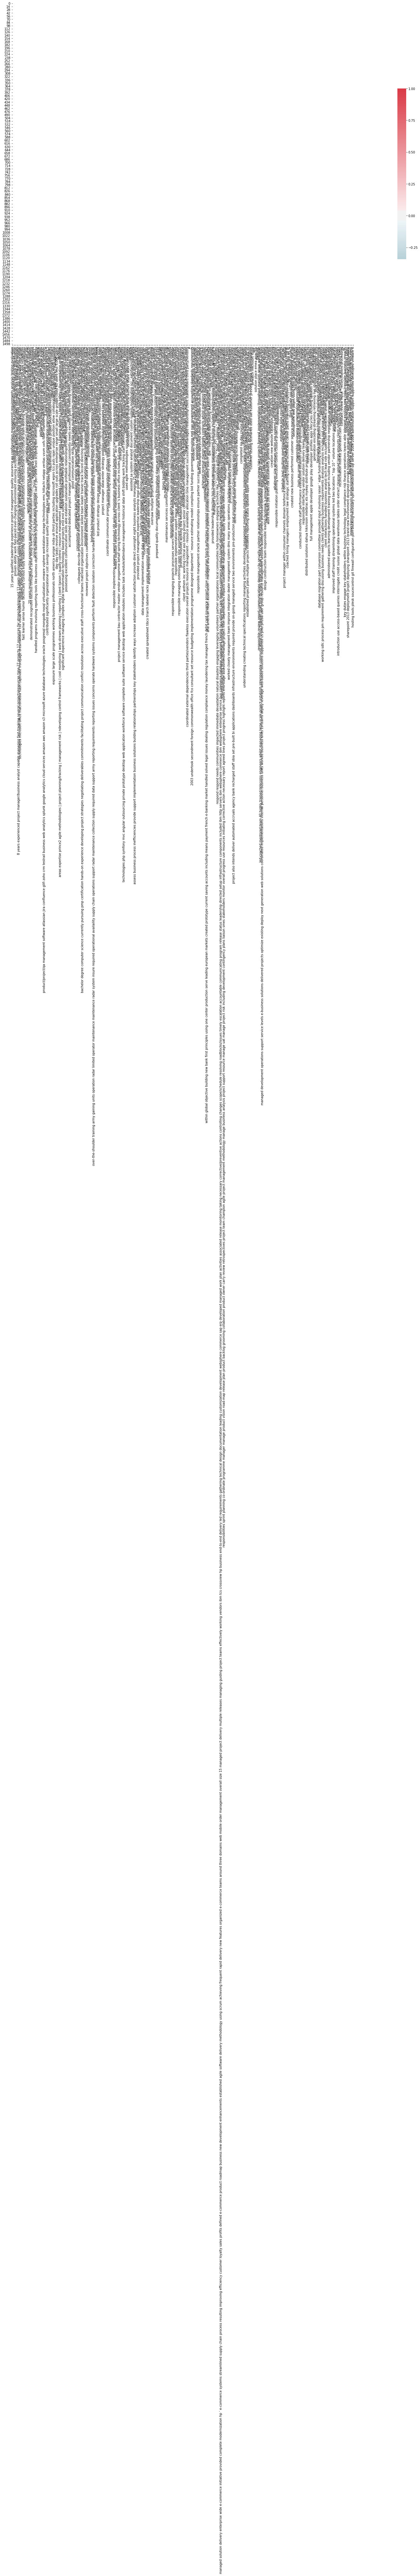

In [232]:
# Generate a mask for the upper triangle
mask = np.zeros_like(dfCos, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(dfCos, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Generación de Embeddings de Sentencia via Doc2Vec

In [13]:
#Infering sentences
def infer_doc2vec(model_name,jobs_labeled):
    model = model_name

    lbl=[]
    emb=[]
#     print(jobs_labeled)
    for job in jobs_labeled:
        model.random.seed(0)
#         print(job)
#         print(job[2])
        vecjob = model.infer_vector(doc_words=job)#, steps=20, alpha=0.025)
#         lbl.append(job[0:2])
        emb.append(vecjob)
    
    docs_emb = {"Labels": lbl
               ,"Embedding": np.array(emb)}
    
    return emb

In [3]:
fpath= os.getcwd()
fmodelname = os.path.join(fpath,'Model/Doc2vecForSentences.model')
model = Doc2Vec.load(fmodelname)

2019-02-13 11:35:38,458 : INFO : loading Doc2Vec object from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model
2019-02-13 11:35:38,589 : INFO : loading trainables recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.trainables.* with mmap=None
2019-02-13 11:35:38,589 : INFO : loading wv recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.wv.* with mmap=None
2019-02-13 11:35:38,589 : INFO : loading vocabulary recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.vocabulary.* with mmap=None
2019-02-13 11:35:38,589 : INFO : loading docvecs recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.docvecs.* with mmap=None
2019-02-13 11:35:38,589 : INFO : loaded C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vec

In [6]:
jobSenD2V=[]
for js in jobSentence:
#     print(js)
    eSenbyDes=infer_doc2vec(model,js[2])
    jobSenD2V.append([js[0],js[1],js[2],eSenbyDes])    
#     break;   

In [7]:
print(len(jobSenD2V))
print(len(jobSenD2V[16][2]))
# print(jobSenD2V[0][3])
# Save of list by sentence
pickle.dump(jobSenD2V, open( os.path.join(fprepath,"jobSenD2V.p"), "wb" ) )

1574
6


In [300]:
pmD2V = []
for jse in jobSenD2V:
    if jse[0].find("project manager or equivalent")!= -1 and jse[0].find("senior project manager or equivalent")== -1:
        pmD2V.append(jse[0:4])

In [301]:
#Verify the total of sentences by job posititon
# c=0
sent2Vec=[]
for pms in pmD2V:
#     c=c+len(pms[2])
    for s in zip(pms[2],pms[3]):
        sent2Vec.append([" ".join(s[0]),s[1]])
#     break
print("Total number of sentences: {}".format(len(sent2Vec)))

Total number of sentences: 1501


In [302]:
#Cosine Similarity calculation
cosineMatS2V= np.zeros((len(sent2Vec),len(sent2Vec)))

#Validation
# for i,z in enumerate(sentEmb):
#     if i == 3:
#         break
#     print (z[0])
# print("#########################")

for x,s1 in enumerate(sent2Vec):
#     if x==3: break
    for y,s2 in enumerate(sent2Vec):
#         print(y)
#         if y==3: break
        sim= round(simil_cos(s1[1],s2[1]),4)
        cosineMatS2V[x][y]=sim
#         print("sentence 1:{}".format(s1[0]))
#         print("sentence 2:{}".format(s2[0]))
#         print("similarity:{}".format(sim))
#         print ("************\n")    

In [303]:
dfCosS2V = pd.DataFrame(cosineMatS2V,columns=[s[0] for s in sent2Vec])
dfCosS2V

,15 years qualified leadership experience project management quality assurance qa configuration management requirements analysis testing evaluation,led integrated software hardware test teams multiple projects,conducted qa/audits highly regulated industries adhering food drug administration regulations iso 9001,extensive experience automated installation entry system aie integrated commercial intrusion detection system icids bio-tech medical equipment enterprise system website testing applications graphic user interface gui,participated system design architecture review,areas expertise full range qa concepts project management scope management time management site management fielding risk management communications management testing test management client vendor relations defining analyzing configuration management requirements gathering agile software development full software developed life cycle acquisition life cycle implementing evaluating improving processes project document review cost controlin cmmi level iii requirements,clearance dod secret government education certifications b,information systems virginia commonwealth university richmond va 2000,information technology project manager strayer university alexandria va anticipated graduation 2017 b,biology old dominion university norfolk va anticipated graduation 2017 dawia level iii certifications acquisition production quality manufacturing dau 2013 dawia level ii product manager dawia level system engineering test evaluation 2014 lean six sigma black belt completed course department defense 2013 pmp progress 2016,...,leepeckgroup previously leepeckgreenfield ltd took manage department whilst delivering number key projects business,key projects project managed successful dns migration 500 websites,responsibilities cover internal external assets including system builds security detailed problem diagnosis resolution adhering strict slas addition writing weekly monthly reports executive level,worked closely support network project sales teams ensure efficient management delivery support technical services internal external customers,managed windows server 2008 environments responsible hosting enviornment 4 dell racks comprising 20 poweredge servers 6 ups systems 2 spares 2 tape carosels 4 cisco routers 1 firewall sonicwall air con,active directory domain services exchange 2007 iis 6 7 dns troubleshooting administration server hardware maintenance installation hp dell backup solutions backup exec,monitoring tools solarwinds,hosting tools plesk soucecontrol git firewall configuration port blocking necessary vpn administration sql server 2005 2008 administration support supported developed vmware 6,5 esxi images team leading experience mentoring setting policies governance meeting service level agreements responsible producing company disaster contingency document produced regular website analysis statistical reports crystal reports sql server 2008 testing beta software,producing test scripts qa staff
0,1.0000,0.4745,0.5011,0.4520,0.4371,0.5394,0.4178,0.4068,0.4635,0.5421,...,0.3469,0.4349,0.2622,0.3248,0.4268,0.3912,0.2394,0.3735,0.4497,0.4390
1,0.4745,1.0000,0.4729,0.4726,0.3986,0.3938,0.4451,0.3680,0.4325,0.4128,...,0.2936,0.5424,0.3444,0.3683,0.4043,0.3795,0.3591,0.4032,0.1700,0.3830
2,0.5011,0.4729,1.0000,0.6110,0.2263,0.4378,0.4569,0.6653,0.5494,0.7277,...,0.6830,0.5578,0.4780,0.3894,0.6574,0.6001,0.6482,0.7077,0.4880,0.4948
3,0.4520,0.4726,0.6110,1.0000,0.3452,0.3115,0.4143,0.5386,0.4305,0.6511,...,0.4397,0.3407,0.2979,0.3172,0.5063,0.5653,0.5267,0.6956,0.4637,0.5210
4,0.4371,0.3986,0.2263,0.3452,1.0000,0.1587,0.3925,0.3735,0.2922,0.3239,...,0.3434,0.3913,0.2596,0.3860,0.3029,0.3177,0.3764,0.4049,0.2266,0.5132
5,0.5394,0.3938,0.4378,0.3115,0.1587,1.0000,0.2681,0.3237,0.3188,0.4295,...,0.4097,0.3669,0.3711,0.0634,0.2743,0.3168,0.3155,0.2576,0.5766,0.2984
6,0.4178,0.4451,0.4569,0.4143,0.3925,0.2681,1.0000,0.5842,0.7062,0.5499,...,0.4735,0.3235,0.3937,0.2880,0.5322,0.3

In [304]:
fprepath= os.path.join(fpath,"Preprocessing/")
dfCosS2V.to_csv(os.path.join(fprepath,"SimCosMatbySent2Vec.csv"))

In [ ]:
def save_tensorboard_proj(loc,dict_emb,lbl_file):
    LOG_DIR = os.path.join(os.getcwd(),loc)
    EMBEDDING_SIZE = len(dict_emb["Embedding"][0])
    VOCA_SIZE = len(dict_emb["Labels"])
    LABEL_FILE = os.path.join(os.getcwd(), os.path.join(loc,lbl_file))
    print("The current working directory:", LOG_DIR,"\n")
    print("the current LABEL_FILE:", LABEL_FILE, "\n")
    Labels=dict_emb["Labels"] 

    #Write label file 
    with open(LABEL_FILE,"w") as f:
        f.write("Generic Job Name\t Real Job Name \t Sencence\n")
        for i in range(VOCA_SIZE):
            f.write("{}\t{}\n".format(Labels[i][0].encode("utf-8"),Labels[i][1].encode("utf-8")))
                           
    print("{} file Created\n".format(lbl_file))
                        
    # word vector of embedding. 
    embedding_input = tf.Variable(dict_emb["Embedding"], dtype=tf.float32, name="input_embedding-no-label")

    # For input of Tensorboard Projector
    embeddings = tf.Variable(tf.zeros([VOCA_SIZE,EMBEDDING_SIZE], name="embedding_intial_tensor"), name="real_Embedding")
    assignment = embeddings.assign(embedding_input) 
    
    # To initilize the variable. 
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(init)
        
        # Format: tensorflow/contrib/tensorboard/plugins/projector/projector_config.proto
        config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
        # You can add multiple embeddings. Here we add only one.
        embedding_config = config.embeddings.add()
        embedding_config.tensor_name = embedding_input.name
        # Link this tensor to its metadata file (e.g. labels).
        embedding_config.metadata_path = LABEL_FILE
        
        # Use the same LOG_DIR where you stored your checkpoint.
        summary_writer = tf.summary.FileWriter(LOG_DIR)
    
        # The next line writes a projector_config.pbtxt in the LOG_DtenIR. TensorBoard will
        # read this file during startup.
        tf.contrib.tensorboard.plugins.projector.visualize_embeddings(summary_writer, config)
    
        save_path1 = saver.save(sess, os.path.join(LOG_DIR, "test_embedding_model.ckpt"), global_step=1)
        print("\nModel Saved in file: %s" % save_path1) 